In [1]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [2]:
playlists = pd.read_csv('Data.csv')
playlists.head()

,album_id,album_name,album_release_date,track_name,artist1_id,album_label
0,671JMBwDOqsTqgUQ1uV31Q,Album for the Young: Gentle Piano by Tchaikovs...,3/29/2014,"Album for the Young, Op. 68 ""Album für die Jug...",4tSF3kfKHwrJHGS7B4UPoK,2014 Ameritz Music Ltd.
1,3CyG8owv9bw92gJ3mJzobY,Asian Zen Spa,4/21/2014,Backroads,6FarM6zyPwNuuVw7lTbMlt,Ocean And Air Records
2,1maoQPAmw44bbkNOxKlwsx,Drukqs,10/22/2001,Avril 14th,6kBDZFXuLrZgHnvmPu9NsG,Warp Records
3,4GFWY45h3wGQlXXQEr5Std,Happy Newage Piano Collection Vol.1,10/31/2013,가질 수 없어도 행복한게 사랑이다,75iUxGnPfWc4gpqs6EzxrM,Hot Ideas
4,21zVmZS6xxjGTAs6bFLUg4,Undertale - Fragments of a Heart,2/22/2016,His Theme (feat. Doug Perry),2K1Ps7vnKg2AnKsSoVqH4P,Various Artists


In [3]:
playlists.shape

(32054, 6)

In [4]:
playlists.columns

Index(['album_id', 'album_name', 'album_release_date', 'track_name',
       'artist1_id', 'album_label'],
      dtype='object')

In [5]:
import re

bad_indices = [] 
lst_4_years = [] 
lst_2_slash = [] 
lst_2_hyphen = [] 

lst_year_release = [] # to store years converted to standardized format YYYY

for i, date in enumerate(playlists.album_release_date):

    if len(date)==4: # keep YYYY as is
        lst_4_years.append(date)
        lst_year_release.append(date)
        
    elif re.findall(r"(.){1,2}[/](.){1,2}[/](.){1,2}",date): # convert MM/DD/YY
        lst_2_slash.append(date)
        
        if int(date[-2:]) < 19: # for years 2000 to 2018
            lst_year_release.append("20"+(date[-2:]))
        else:
            lst_year_release.append("19"+(date[-2:])) # for years 1939 (oldest year) to 1999
        
    elif re.findall(r"(.){4}-(.){2}",date): # convert YYYY-MM
        lst_2_hyphen.append(date)
        lst_year_release.append(date[:4])
        
    else:
        bad_indices.append((i, date))
        
print(len(bad_indices)) # there are no bad indices :) that means all release dates were in one of the above 3 formats
playlists["album_release_year"] = lst_year_release

0


In [6]:
playlists.columns

Index(['album_id', 'album_name', 'album_release_date', 'track_name',
       'artist1_id', 'album_label', 'album_release_year'],
      dtype='object')

In [7]:
data = playlists[['album_id', 'album_name', 'track_name', 'artist1_id', 'album_label', 'album_release_year']]

In [8]:
data.head()

,album_id,album_name,track_name,artist1_id,album_label,album_release_year
0,671JMBwDOqsTqgUQ1uV31Q,Album for the Young: Gentle Piano by Tchaikovs...,"Album for the Young, Op. 68 ""Album für die Jug...",4tSF3kfKHwrJHGS7B4UPoK,2014 Ameritz Music Ltd.,2014
1,3CyG8owv9bw92gJ3mJzobY,Asian Zen Spa,Backroads,6FarM6zyPwNuuVw7lTbMlt,Ocean And Air Records,2014
2,1maoQPAmw44bbkNOxKlwsx,Drukqs,Avril 14th,6kBDZFXuLrZgHnvmPu9NsG,Warp Records,2001
3,4GFWY45h3wGQlXXQEr5Std,Happy Newage Piano Collection Vol.1,가질 수 없어도 행복한게 사랑이다,75iUxGnPfWc4gpqs6EzxrM,Hot Ideas,2013
4,21zVmZS6xxjGTAs6bFLUg4,Undertale - Fragments of a Heart,His Theme (feat. Doug Perry),2K1Ps7vnKg2AnKsSoVqH4P,Various Artists,2016


In [9]:
data.shape

(32054, 6)

# Data Cleaning

In [10]:
data=data.dropna(axis=0)
data.shape

(32044, 6)

In [11]:
print(sum(data.duplicated('track_name')))

14746


In [12]:
data.sort_values('track_name',inplace=True, ascending=False)
data.head()

,album_id,album_name,track_name,artist1_id,album_label,album_release_year
6040,0dCnMD2QwTKrAJKS1zH9s6,A’s Doll House - EP,열애설 (Scandal),3uGFTJ7JMllvhgGpumieHF,YMC엔터테인먼트 (YMC Ent.),2013
757,4O6r59fmhMgcNxzVvEgaj9,For Your Heart Vol.1,시간을 타고,0BeIulKOpcvsabwlt4u8qp,Emotion Piano,2013
14417,4RL2SyHa8y9t1cKLQr399v,Watch,바보같은 여자라,5tsAGzBkkAM9DtfYfJy456,쏘스뮤직,2011
233,1B6ZdAcCctpZafBay3g4sI,피아노 선율에 그리움을 담아,그리운 이에게,0BeIulKOpcvsabwlt4u8qp,Emotion Piano,2013
12,2iTg1bg66Ug0hgXrl6Of8L,사랑을 그리는 뉴에이지 피아노,공주를 사랑한 피아니스트,0BeIulKOpcvsabwlt4u8qp,Emotion Piano,2013


In [13]:
indices = []
for i,row in data.iterrows():
    indices.append(i)

In [14]:
import itertools
stage1_dedupe_track_name = []
i = 0
j = 0
num_data_points = data.shape[0]
while i < num_data_points and j < num_data_points:
    
    previous_i = i
    a = data['track_name'].loc[indices[i]].split()
    j = i+1
    while j < num_data_points:        
        b = data['track_name'].loc[indices[j]].split()
        length = max(len(a), len(b))
        count  = 0
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1
        if (length - count) > 1:
            stage1_dedupe_track_name.append(data['track_name'].loc[indices[i]])
            if j == num_data_points-1: stage1_dedupe_track_name.append(data['track_name'].loc[indices[j]])

            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [15]:
data = data.loc[data['track_name'].isin(stage1_dedupe_track_name)]

In [16]:
print('Number of data points : ', data.shape[0])

Number of data points :  26710


In [17]:
def plot_heatmap(keys, values, labels,text):
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(20,2))
        ax = plt.subplot(gs[0])
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) 
        ax.set_title(text) 
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2,text, model):

    intersection = set(vec1.keys()) & set(vec2.keys()) 
    for i in vec2:
        if i not in intersection:
            vec2[i]=0
    keys = list(vec2.keys())
    values = [vec2[x] for x in vec2.keys()]
    if model == 'bag_of_words':
        labels = values

    plot_heatmap(keys, values, labels, text)

def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    return Counter(words) 


def get_result(doc_id, content_a, content_b, model):
    text1 = content_a
    text2 = content_b
    vector1 = text_to_vector(text1)
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, text2, model)

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['album_name'])
title_features.get_shape()

(26710, 8051)

# Bag of words 

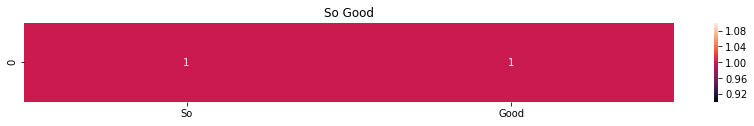

track_name : So Good
album_name: So Good
album_label: Columbia
year: 2017
Euclidean similarity : 0.0


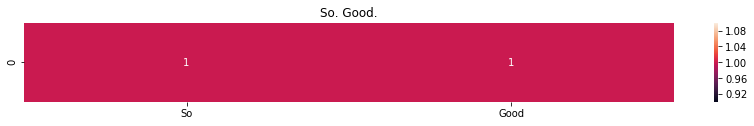

track_name : So. Good.
album_name: So. Good.
album_label: Johnny Stimson
year: 2015
Euclidean similarity : 0.0


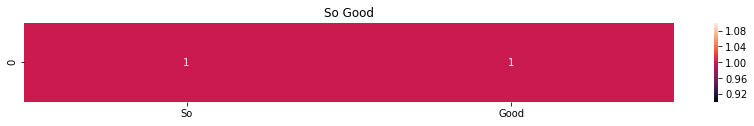

track_name : I Would Like
album_name: So Good
album_label: Epic/Record Company TEN
year: 2017
Euclidean similarity : 0.0


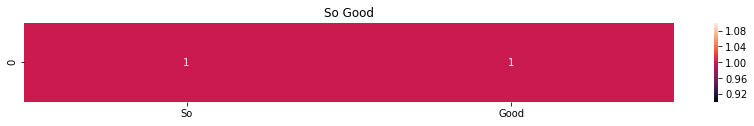

track_name : Lush Life
album_name: So Good
album_label: Epic/Record Company TEN
year: 2017
Euclidean similarity : 0.0


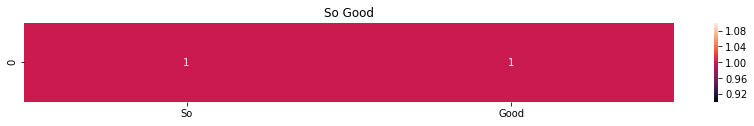

track_name : Ain't My Fault
album_name: So Good
album_label: Universal Music AB
year: 2017
Euclidean similarity : 0.0


In [19]:
def bag_of_words_model(doc_id, num_results):
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        get_result(indices[i],data['track_name'].loc[df_indices[0]], data['album_name'].loc[df_indices[i]], 'bag_of_words')
        print('track_name :',data['track_name'].loc[df_indices[i]])
        print ('album_name:', data['album_name'].loc[df_indices[i]])
        print ('album_label:', data['album_label'].loc[df_indices[i]])
        print ('year:', data['album_release_year'].loc[df_indices[i]])
        print ('Euclidean similarity :', pdists[i])
        print('='*60)

bag_of_words_model(12500,5) 